In [1]:
import tensorflow as tf
from matplotlib import animation
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from IPython.display import HTML
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from datetime import timedelta
sns.set()

In [2]:
class Model:
    def __init__(self, learning_rate, num_layers, size, size_layer, output_size, forget_bias = 0.1):
        
        def lstm_cell(size_layer):
            return tf.nn.rnn_cell.LSTMCell(size_layer, state_is_tuple = False)
        rnn_cells = tf.nn.rnn_cell.MultiRNNCell([lstm_cell(size_layer) for _ in range(num_layers)], 
                                                state_is_tuple = False)
        self.X = tf.placeholder(tf.float32, (None, None, size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        drop = tf.contrib.rnn.DropoutWrapper(rnn_cells, output_keep_prob = forget_bias)
        self.hidden_layer = tf.placeholder(tf.float32, (None, num_layers * 2 * size_layer))
        self.outputs, self.last_state = tf.nn.dynamic_rnn(drop, self.X, 
                                                          initial_state = self.hidden_layer, 
                                                          dtype = tf.float32)
        rnn_W = tf.Variable(tf.random_normal((size_layer, output_size)))
        rnn_B = tf.Variable(tf.random_normal([output_size]))
        self.logits = tf.matmul(self.outputs[-1], rnn_W) + rnn_B
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(self.cost)

In [3]:
df = pd.read_csv('GOOG-year.csv')
date_ori = pd.to_datetime(df.iloc[:, 0]).tolist()
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-11-02,778.200012,781.650024,763.450012,768.700012,768.700012,1872400
1,2016-11-03,767.250000,769.950012,759.030029,762.130005,762.130005,1943200
2,2016-11-04,750.659973,770.359985,750.560974,762.020020,762.020020,2134800
3,2016-11-07,774.500000,785.190002,772.549988,782.520020,782.520020,1585100
4,2016-11-08,783.400024,795.632996,780.190002,790.510010,790.510010,1350800


In [4]:
minmax = MinMaxScaler().fit(df.iloc[:, 4:5].astype('float32'))
df_log = minmax.transform(df.iloc[:, 4:5].astype('float32'))
df_log = pd.DataFrame(df_log)
df_log.head()

,0
0,0.112708
1,0.090008
2,0.089628
3,0.160459
4,0.188066


In [5]:
num_layers = 1
size_layer = 128
timestamp = 5
epoch = 500
dropout_rate = 0.8
future_day = 50

In [6]:
for i in range(future_day):
    date_ori.append(date_ori[-1]+timedelta(days=1))

In [7]:
modelnn = Model(0.01, num_layers, df_log.shape[1], size_layer, df_log.shape[1], dropout_rate)
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

epoch: 50 ,mse: Close    157.447387
dtype: float64
epoch: 100 ,mse: Close    138.647608
dtype: float64


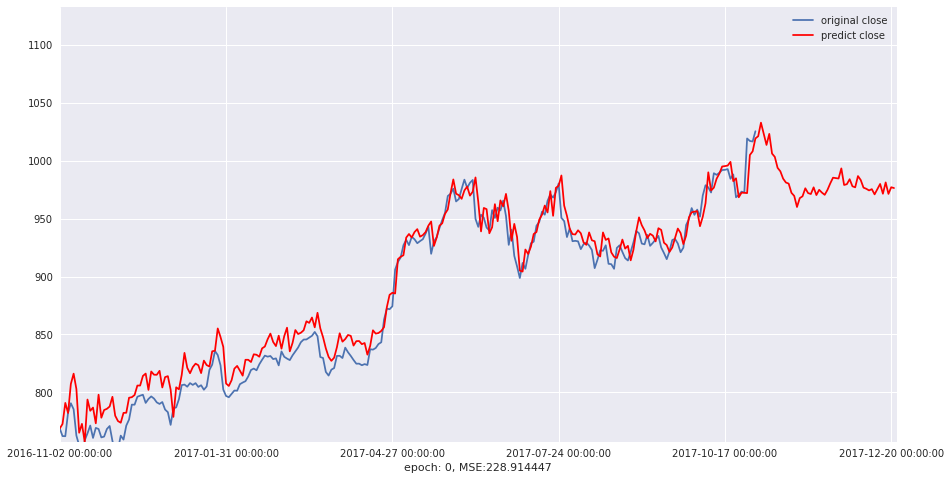

In [8]:
fig = plt.figure(figsize=(15,8))
ax = plt.axes()
ax.plot(np.arange(df.shape[0]),df.Close,label='original close')
line, = ax.plot([],[],label='predict close', c='r')
ax.legend()
ax.set_xlim([0, df.shape[0]+future_day])
x_range_future=np.arange(df.shape[0]+future_day)
plt.xticks(x_range_future[::60], date_ori[::60])
ax.set_xlabel('epoch: %d, MSE:%f'%(0, np.inf))

def train(epoch):
    df_log = minmax.transform(df.iloc[:, 4:5].astype('float32'))
    df_log = pd.DataFrame(df_log)
    init_value = np.zeros((1, num_layers * 2 * size_layer))
    for k in range(0, (df_log.shape[0] // timestamp) * timestamp, timestamp):
        batch_x = np.expand_dims(df_log.iloc[k: k + timestamp, :].values, axis = 0)
        batch_y = df_log.iloc[k + 1: k + timestamp + 1, :].values
        last_state, _, loss = sess.run([modelnn.last_state, 
                                        modelnn.optimizer, 
                                        modelnn.cost], feed_dict={modelnn.X: batch_x, 
                                                                  modelnn.Y: batch_y, 
                                                                  modelnn.hidden_layer: init_value})
        init_value = last_state
    output_predict = np.zeros((df_log.shape[0] + future_day, df_log.shape[1]))
    output_predict[0, :] = df_log.iloc[0, :]
    upper_b = (df_log.shape[0] // timestamp) * timestamp
    init_value = np.zeros((1, num_layers * 2 * size_layer))
    for k in range(0, (df_log.shape[0] // timestamp) * timestamp, timestamp):
        out_logits, last_state = sess.run([modelnn.logits, modelnn.last_state], 
                                          feed_dict = {modelnn.X:np.expand_dims(df_log.iloc[k: k + timestamp, :], axis = 0),
                                                       modelnn.hidden_layer: init_value})
        init_value = last_state
        output_predict[k + 1: k + timestamp + 1, :] = out_logits
    out_logits, last_state = sess.run([modelnn.logits, modelnn.last_state], 
                                      feed_dict = {modelnn.X:np.expand_dims(df_log.iloc[upper_b: , :], axis = 0),
                                                   modelnn.hidden_layer: init_value})
    init_value = last_state
    output_predict[upper_b + 1: df_log.shape[0] + 1, :] = out_logits
    df_log.loc[df_log.shape[0]] = out_logits[-1, :]
    for i in range(future_day - 1):
        out_logits, last_state = sess.run([modelnn.logits, modelnn.last_state], 
                                          feed_dict = {modelnn.X:np.expand_dims(df_log.iloc[-timestamp:, :], axis = 0),
                                                       modelnn.hidden_layer: init_value})
        init_value = last_state
        output_predict[df_log.shape[0], :] = out_logits[-1, :]
        df_log.loc[df_log.shape[0]] = out_logits[-1, :]
        date_ori.append(date_ori[-1]+timedelta(days=1))
    df_log = minmax.inverse_transform(output_predict)
    mse = np.mean(np.square(df.iloc[:, 4:5] - df_log[:df.shape[0],:]))
    if(epoch+1) % 50 == 0:
        print('epoch:', epoch+1, ',mse:', mse)
    line.set_data(np.arange(df_log.shape[0]),df_log[:,0])
    ax.set_ylim([np.min(df_log[:,0]), np.max(df_log[:,0])+100])
    ax.set_xlabel('epoch: %d, MSE:%f'%(epoch, mse))
    return line, ax

# train for 500 epoch
anim = animation.FuncAnimation(fig, train, frames=100, interval=200)
anim.save('animation-stock-forecasting.gif', writer='imagemagick', fps=10)